In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor
import matplotlib.pyplot as plt

# Load Data

In [2]:
gr = pd.read_csv('official_goodreads_metadata.csv')
am = pd.read_csv('official_amazon_metadata.csv')
am_gr = pd.merge(gr[['asin', 'average_rating', 'total_ratings_count', 'total_text_reviews_count', 'publication_year', 
                     'publication_month', 'publication_day', 'num_pages', 'format', 'cleaned_description', 'gr_countDes_before', 
                     'gr_countDes_after', 'cleaned_genres', 'gr_countText_before', 'gr_countText_after']], 
                 am[['asin', 'average', 'rating_count', 'text_reviews_count', 'rank', 'verifiedTrue_count', 'Format',
                     'am_countText_before', 'am_countText_after']], how='inner', on='asin')
am_gr

,asin,average_rating,total_ratings_count,total_text_reviews_count,publication_year,publication_month,publication_day,num_pages,format,cleaned_description,...,gr_countText_before,gr_countText_after,average,rating_count,text_reviews_count,rank,verifiedTrue_count,Format,am_countText_before,am_countText_after
0,000100039X,4.23,220088,8847,2010.0,1.0,1.0,127.0,Paperback,tahsil vibrants masterpiece prophet one belove...,...,42320,17834,4.64,1453,1453,1810945,1130,NaN,69909,31772
1,0001053655,4.08,676,85,1997.0,NaN,NaN,268.0,Hardcover,NaN,...,158,75,4.48,50,50,9799161,43,"Kindle Edition, Paperback, Hardcover, Audi...",4888,2240
2,0001061240,4.62,221,36,1959.0,12.0,1.0,324.0,Hardcover,NaN,...,49,18,4.87,45,45,321557,30,Hardcover,3085,1326
3,000161102X,3.86,2929,75,NaN,NaN,NaN,190.0,NaN,snobby girl fashionable board school ridicule ...,...,130,61,4.35,17,17,1542999,13,NaN,788,399
4,0001711296,4.29,738,65,NaN,NaN,NaN,63.0,NaN,NaN,...,257,117,4.44,107,107,2884610,69,"Library Binding, VHS Tape, Paperback, Hard...",5667,2574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37228,0312953240,3.80,87,8,1995.0,7.0,15.0,570.0,Paperback,recount search trial serial killer target offr...,...,219,94,3.69,13,13,443719,4,"Mass Market Paperback, Hardcover",2599,1216
37229,0312955138,3.38,29,4,1995.0,9.0,15.0,320.0,Paperback,jill coit voluptuous darkskinned beauty sultry...,...,125,52,3.58,12,12,3470182,6,"Kindle Edition, Hardcover",1489,668
37230,0312955154,3.36,56,5,1995.0,10.0,15.0,NaN,Paperback,paleontologist cameron alone discover yearly m...,...,362,184,3.29,14,14,3412599,4,"Kindle Edition, Paperback",1456,683
37231,0312956878,3.78,59,4,1995.0,10.0,15.0,608.0,Paperback,killer without redemption broad daylight backw...,...,152,76,3.33,15,15,2606128,9,"Mass Market Paperback, Hardcover",968,450


In [4]:
am_gr = am_gr.rename(columns={'average_rating':'gr_average', 'total_ratings_count':'gr_ratings_count',
                              'total_text_reviews_count':'gr_reviews_count', 'publication_year':'gr_pub_yr', 
                              'publication_month':'gr_pub_mo', 'publication_day':'gr_pub_day', 'num_pages':'gr_num_pages', 
                              'format':'gr_format', 'cleaned_description':'gr_description', 'cleaned_genres':'gr_genres',
                              'average':'am_average', 'rating_count':'am_ratings_count', 'text_reviews_count':'am_reviews_count', 
                              'rank':'am_rank', 'verifiedTrue_count':'am_verifiedTrue_count', 'Format':'am_format'})

In [5]:
col_names=["asin", "prop_topic_1", "prop_topic_2", "prop_topic_3", "prop_topic_4", 'prop_topic_5', 'prop_topic_6', 
           'prop_topic_7', 'prop_topic_8', 'prop_topic_9', 'prop_topic_10']
lda_gen = pd.read_csv('am_gr_LDA_step5_metadata.csv', names=col_names)

In [6]:
lda_gen

,asin,prop_topic_1,prop_topic_2,prop_topic_3,prop_topic_4,prop_topic_5,prop_topic_6,prop_topic_7,prop_topic_8,prop_topic_9,prop_topic_10
0,0001713353,0.000000,0.000000,0.000000,0.000000,0.035829,0.944674,0.000000,0.000000,0.010132,0.000000
1,0001061240,0.000000,0.000000,0.000000,0.000000,0.022678,0.960657,0.000000,0.000000,0.013664,0.000000
2,0001711296,0.000000,0.000000,0.017237,0.000000,0.060253,0.887754,0.000000,0.000000,0.017332,0.000000
3,0002007649,0.032234,0.000000,0.000000,0.000000,0.014494,0.000000,0.399840,0.131761,0.000000,0.412079
4,0001716069,0.000000,0.000000,0.056557,0.026173,0.051585,0.828228,0.000000,0.000000,0.023740,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
37228,0312943636,0.000000,0.321645,0.071768,0.434701,0.000000,0.087001,0.000000,0.026738,0.000000,0.045392
37229,0312953038,0.016848,0.268765,0.119893,0.299400,0.037515,0.053613,0.000000,0.025559,0.034230,0.143670
37230,0312955154,0.019026,0.291277,0.142345,0.122231,0.065309,0.028764,0.049903,0.053601,0.100960,0.126584
37231,0312956878,0.071949,0.105398,0.026594,0.000000,0.255959,0.025761,0.308752,0.134243,0.059607,0.000000


In [7]:
col_names=["asin", "prop_topic_1", "prop_topic_2", "prop_topic_3", "prop_topic_4", 'prop_topic_5', 'prop_topic_6', 
           'prop_topic_7', 'prop_topic_8', 'prop_topic_9', 'prop_topic_10', 'delete']
lda_mallet = pd.read_csv('am_gr_lda_metadata_wmallet_10topics.csv', names=col_names)
lda_mallet = lda_mallet.drop('delete', axis=1)
lda_mallet

,asin,prop_topic_1,prop_topic_2,prop_topic_3,prop_topic_4,prop_topic_5,prop_topic_6,prop_topic_7,prop_topic_8,prop_topic_9,prop_topic_10
0,0001713353,0.051038,0.018866,0.020753,0.038229,0.016284,0.718697,0.024824,0.014001,0.035051,0.062258
1,0001061240,0.024777,0.032617,0.019454,0.011808,0.012195,0.783295,0.048780,0.036005,0.016551,0.014518
2,0001711296,0.032466,0.014493,0.021298,0.040258,0.037349,0.721677,0.053608,0.013817,0.034492,0.030544
3,0002007649,0.295647,0.005536,0.006731,0.094017,0.008016,0.008060,0.008680,0.015411,0.547939,0.009964
4,0001716069,0.044247,0.037673,0.018377,0.040430,0.023537,0.673381,0.027283,0.016822,0.034846,0.083404
...,...,...,...,...,...,...,...,...,...,...,...
37228,0312943636,0.017039,0.126679,0.004580,0.011723,0.298709,0.095567,0.025440,0.009659,0.008282,0.402321
37229,0312953038,0.015675,0.563066,0.091599,0.027186,0.032248,0.015267,0.042616,0.013715,0.016328,0.182301
37230,0312955154,0.051609,0.061779,0.083485,0.024287,0.360959,0.059199,0.036278,0.025956,0.112933,0.183515
37231,0312956878,0.034083,0.055215,0.033629,0.236083,0.285390,0.039309,0.186549,0.037719,0.053624,0.038400


# Clean Data

In [8]:
am_gr.describe()

,gr_average,gr_ratings_count,gr_reviews_count,gr_pub_yr,gr_pub_mo,gr_pub_day,gr_num_pages,gr_countDes_before,gr_countDes_after,gr_countText_before,gr_countText_after,am_average,am_ratings_count,am_reviews_count,am_rank,am_verifiedTrue_count,am_countText_before,am_countText_after
count,37233.000000,3.723300e+04,37233.000000,35788.000000,35221.000000,35021.000000,35603.000000,36206.000000,35485.000000,3.723300e+04,37233.000000,37233.000000,37233.000000,37233.000000,3.723300e+04,37233.000000,3.723300e+04,3.723300e+04
mean,3.873311,1.147746e+04,614.953992,2005.668772,6.367764,13.958339,322.277757,160.689085,89.978442,3.233221e+03,1429.169957,4.261219,152.651680,152.615798,1.563020e+06,104.396879,1.371004e+04,6.490044e+03
std,0.306148,8.537788e+04,3121.161743,8.987800,3.339121,10.365574,201.544695,92.759441,52.634720,1.502964e+04,6492.465045,0.422799,702.459338,702.255076,2.092905e+06,569.410575,4.245893e+04,1.970582e+04
min,2.320000,1.000000e+00,0.000000,1900.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000e+00,0.000000,1.080000,6.000000,6.000000,2.300000e+01,0.000000,7.900000e+01,4.900000e+01
25%,3.690000,2.270000e+02,27.000000,2002.000000,4.000000,4.000000,227.000000,99.000000,55.000000,1.480000e+02,68.000000,4.040000,22.000000,22.000000,3.022940e+05,11.000000,2.395000e+03,1.152000e+03
50%,3.890000,8.210000e+02,83.000000,2008.000000,6.000000,13.000000,307.000000,147.000000,81.000000,5.740000e+02,260.000000,4.330000,43.000000,43.000000,9.232760e+05,24.000000,4.956000e+03,2.387000e+03
75%,4.080000,3.416000e+03,292.000000,2012.000000,9.000000,24.000000,384.000000,205.000000,115.000000,2.058000e+03,928.000000,4.570000,107.000000,107.000000,1.986080e+06,66.000000,1.170400e+04,5.585000e+03
max,5.000000,4.718437e+06,152766.000000,2019.000000,12.000000,31.000000,9998.000000,2124.000000,1250.000000,1.001655e+06,443150.000000,5.000000,44956.000000,44947.000000,2.154444e+07,39851.000000,2.384912e+06,1.082212e+06


In [9]:
gr[gr['total_text_reviews_count'] == 0]

,asin,average_rating,ratings_count,reviews_count,text_reviews_count,total_ratings_count,total_reviews_count,total_text_reviews_count,publication_year,publication_month,...,publisher,num_pages,format,description,cleaned_description,gr_countDes_before,gr_countDes_after,cleaned_genres,gr_countText_before,gr_countText_after
24788,0205739415,2.92,8,32,0,12,46,0,2010.0,9.0,...,Longman Publishing Group,544.0,Paperback,"""Technical Communication Strategies for Today ...",technical communication strategy today offer s...,147.0,92.0,non-fiction,96,40
26677,0300084323,4.35,23,86,0,23,86,0,2001.0,3.0,...,Yale University Press,816.0,Hardcover,The Holocaust has been the subject of countles...,holocaust subject countless book work art memo...,214.0,134.0,"history, historical fiction, biography, fictio...",2,2


In [10]:
am_gr.loc[am_gr['asin'] == '0205739415', 'gr_reviews_count'] = 32
am_gr.loc[am_gr['asin'] == '0300084323', 'gr_reviews_count'] = 86

In [11]:
am_gr.describe()

,gr_average,gr_ratings_count,gr_reviews_count,gr_pub_yr,gr_pub_mo,gr_pub_day,gr_num_pages,gr_countDes_before,gr_countDes_after,gr_countText_before,gr_countText_after,am_average,am_ratings_count,am_reviews_count,am_rank,am_verifiedTrue_count,am_countText_before,am_countText_after
count,37233.000000,3.723300e+04,37233.000000,35788.000000,35221.000000,35021.000000,35603.000000,36206.000000,35485.000000,3.723300e+04,37233.000000,37233.000000,37233.000000,37233.000000,3.723300e+04,37233.000000,3.723300e+04,3.723300e+04
mean,3.873311,1.147746e+04,614.957162,2005.668772,6.367764,13.958339,322.277757,160.689085,89.978442,3.233221e+03,1429.169957,4.261219,152.651680,152.615798,1.563020e+06,104.396879,1.371004e+04,6.490044e+03
std,0.306148,8.537788e+04,3121.161155,8.987800,3.339121,10.365574,201.544695,92.759441,52.634720,1.502964e+04,6492.465045,0.422799,702.459338,702.255076,2.092905e+06,569.410575,4.245893e+04,1.970582e+04
min,2.320000,1.000000e+00,1.000000,1900.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000e+00,0.000000,1.080000,6.000000,6.000000,2.300000e+01,0.000000,7.900000e+01,4.900000e+01
25%,3.690000,2.270000e+02,27.000000,2002.000000,4.000000,4.000000,227.000000,99.000000,55.000000,1.480000e+02,68.000000,4.040000,22.000000,22.000000,3.022940e+05,11.000000,2.395000e+03,1.152000e+03
50%,3.890000,8.210000e+02,83.000000,2008.000000,6.000000,13.000000,307.000000,147.000000,81.000000,5.740000e+02,260.000000,4.330000,43.000000,43.000000,9.232760e+05,24.000000,4.956000e+03,2.387000e+03
75%,4.080000,3.416000e+03,292.000000,2012.000000,9.000000,24.000000,384.000000,205.000000,115.000000,2.058000e+03,928.000000,4.570000,107.000000,107.000000,1.986080e+06,66.000000,1.170400e+04,5.585000e+03
max,5.000000,4.718437e+06,152766.000000,2019.000000,12.000000,31.000000,9998.000000,2124.000000,1250.000000,1.001655e+06,443150.000000,5.000000,44956.000000,44947.000000,2.154444e+07,39851.000000,2.384912e+06,1.082212e+06


In [12]:
am_gr['gr_num_pages'] = am_gr['gr_num_pages'].replace(0, np.mean(am_gr['gr_num_pages']))

In [13]:
am_gr.describe()

,gr_average,gr_ratings_count,gr_reviews_count,gr_pub_yr,gr_pub_mo,gr_pub_day,gr_num_pages,gr_countDes_before,gr_countDes_after,gr_countText_before,gr_countText_after,am_average,am_ratings_count,am_reviews_count,am_rank,am_verifiedTrue_count,am_countText_before,am_countText_after
count,37233.000000,3.723300e+04,37233.000000,35788.000000,35221.000000,35021.000000,35603.000000,36206.000000,35485.000000,3.723300e+04,37233.000000,37233.000000,37233.000000,37233.000000,3.723300e+04,37233.000000,3.723300e+04,3.723300e+04
mean,3.873311,1.147746e+04,614.957162,2005.668772,6.367764,13.958339,323.246320,160.689085,89.978442,3.233221e+03,1429.169957,4.261219,152.651680,152.615798,1.563020e+06,104.396879,1.371004e+04,6.490044e+03
std,0.306148,8.537788e+04,3121.161155,8.987800,3.339121,10.365574,200.766459,92.759441,52.634720,1.502964e+04,6492.465045,0.422799,702.459338,702.255076,2.092905e+06,569.410575,4.245893e+04,1.970582e+04
min,2.320000,1.000000e+00,1.000000,1900.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000e+00,0.000000,1.080000,6.000000,6.000000,2.300000e+01,0.000000,7.900000e+01,4.900000e+01
25%,3.690000,2.270000e+02,27.000000,2002.000000,4.000000,4.000000,229.000000,99.000000,55.000000,1.480000e+02,68.000000,4.040000,22.000000,22.000000,3.022940e+05,11.000000,2.395000e+03,1.152000e+03
50%,3.890000,8.210000e+02,83.000000,2008.000000,6.000000,13.000000,308.000000,147.000000,81.000000,5.740000e+02,260.000000,4.330000,43.000000,43.000000,9.232760e+05,24.000000,4.956000e+03,2.387000e+03
75%,4.080000,3.416000e+03,292.000000,2012.000000,9.000000,24.000000,384.000000,205.000000,115.000000,2.058000e+03,928.000000,4.570000,107.000000,107.000000,1.986080e+06,66.000000,1.170400e+04,5.585000e+03
max,5.000000,4.718437e+06,152766.000000,2019.000000,12.000000,31.000000,9998.000000,2124.000000,1250.000000,1.001655e+06,443150.000000,5.000000,44956.000000,44947.000000,2.154444e+07,39851.000000,2.384912e+06,1.082212e+06


In [14]:
am_gr['ratings_count'] = am_gr['gr_ratings_count'] + am_gr['am_ratings_count']
am_gr['reviews_count'] = am_gr['gr_reviews_count'] + am_gr['am_reviews_count']
am_gr['rating_diff'] = am_gr['am_average'] - am_gr['gr_average']
am_gr = am_gr.drop(['gr_ratings_count', 'am_ratings_count', 'gr_reviews_count', 'am_reviews_count', 'am_average', 'gr_average'],
                   axis=1)

In [15]:
am_gr.isnull().sum()

asin                        0
gr_pub_yr                1445
gr_pub_mo                2012
gr_pub_day               2212
gr_num_pages             1630
gr_format                1535
gr_description           1748
gr_countDes_before       1027
gr_countDes_after        1748
gr_genres                 199
gr_countText_before         0
gr_countText_after          0
am_rank                     0
am_verifiedTrue_count       0
am_format                  49
am_countText_before         0
am_countText_after          0
ratings_count               0
reviews_count               0
rating_diff                 0
dtype: int64

In [16]:
am_gr.to_csv('official_am_gr_metadata.csv', header=True)

In [17]:
lda_gen = pd.merge(lda_gen, am_gr, on='asin', how='inner')
lda_gen

,asin,prop_topic_1,prop_topic_2,prop_topic_3,prop_topic_4,prop_topic_5,prop_topic_6,prop_topic_7,prop_topic_8,prop_topic_9,...,gr_countText_before,gr_countText_after,am_rank,am_verifiedTrue_count,am_format,am_countText_before,am_countText_after,ratings_count,reviews_count,rating_diff
0,0001713353,0.000000,0.000000,0.000000,0.000000,0.035829,0.944674,0.000000,0.000000,0.010132,...,600,268,1461315,36,"Paperback, Hardcover",2362,1037,691,109,0.56
1,0001061240,0.000000,0.000000,0.000000,0.000000,0.022678,0.960657,0.000000,0.000000,0.013664,...,49,18,321557,30,Hardcover,3085,1326,266,81,0.25
2,0001711296,0.000000,0.000000,0.017237,0.000000,0.060253,0.887754,0.000000,0.000000,0.017332,...,257,117,2884610,69,"Library Binding, VHS Tape, Paperback, Hard...",5667,2574,845,172,0.15
3,0002007649,0.032234,0.000000,0.000000,0.000000,0.014494,0.000000,0.399840,0.131761,0.000000,...,356,166,9799524,3,"Kindle Edition, Paperback, Hardcover",5668,2810,375,60,-0.20
4,0001716069,0.000000,0.000000,0.056557,0.026173,0.051585,0.828228,0.000000,0.000000,0.023740,...,1090,509,3841172,44,"Kindle Edition, Paperback, Hardcover",3081,1457,1618,161,0.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37228,0312943636,0.000000,0.321645,0.071768,0.434701,0.000000,0.087001,0.000000,0.026738,0.000000,...,7453,3353,2583900,9,"Mass Market Paperback, Kindle Edition",5228,2508,1819,158,0.44
37229,0312953038,0.016848,0.268765,0.119893,0.299400,0.037515,0.053613,0.000000,0.025559,0.034230,...,451,210,553268,12,"Mass Market Paperback, Kindle Edition, Pape...",3184,1420,1155,86,0.25
37230,0312955154,0.019026,0.291277,0.142345,0.122231,0.065309,0.028764,0.049903,0.053601,0.100960,...,362,184,3412599,4,"Kindle Edition, Paperback",1456,683,70,19,-0.07
37231,0312956878,0.071949,0.105398,0.026594,0.000000,0.255959,0.025761,0.308752,0.134243,0.059607,...,152,76,2606128,9,"Mass Market Paperback, Hardcover",968,450,74,19,-0.45


In [18]:
lda_mallet = pd.merge(lda_mallet, am_gr, on='asin', how='inner')
lda_mallet

,asin,prop_topic_1,prop_topic_2,prop_topic_3,prop_topic_4,prop_topic_5,prop_topic_6,prop_topic_7,prop_topic_8,prop_topic_9,...,gr_countText_before,gr_countText_after,am_rank,am_verifiedTrue_count,am_format,am_countText_before,am_countText_after,ratings_count,reviews_count,rating_diff
0,0001713353,0.051038,0.018866,0.020753,0.038229,0.016284,0.718697,0.024824,0.014001,0.035051,...,600,268,1461315,36,"Paperback, Hardcover",2362,1037,691,109,0.56
1,0001061240,0.024777,0.032617,0.019454,0.011808,0.012195,0.783295,0.048780,0.036005,0.016551,...,49,18,321557,30,Hardcover,3085,1326,266,81,0.25
2,0001711296,0.032466,0.014493,0.021298,0.040258,0.037349,0.721677,0.053608,0.013817,0.034492,...,257,117,2884610,69,"Library Binding, VHS Tape, Paperback, Hard...",5667,2574,845,172,0.15
3,0002007649,0.295647,0.005536,0.006731,0.094017,0.008016,0.008060,0.008680,0.015411,0.547939,...,356,166,9799524,3,"Kindle Edition, Paperback, Hardcover",5668,2810,375,60,-0.20
4,0001716069,0.044247,0.037673,0.018377,0.040430,0.023537,0.673381,0.027283,0.016822,0.034846,...,1090,509,3841172,44,"Kindle Edition, Paperback, Hardcover",3081,1457,1618,161,0.79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37228,0312943636,0.017039,0.126679,0.004580,0.011723,0.298709,0.095567,0.025440,0.009659,0.008282,...,7453,3353,2583900,9,"Mass Market Paperback, Kindle Edition",5228,2508,1819,158,0.44
37229,0312953038,0.015675,0.563066,0.091599,0.027186,0.032248,0.015267,0.042616,0.013715,0.016328,...,451,210,553268,12,"Mass Market Paperback, Kindle Edition, Pape...",3184,1420,1155,86,0.25
37230,0312955154,0.051609,0.061779,0.083485,0.024287,0.360959,0.059199,0.036278,0.025956,0.112933,...,362,184,3412599,4,"Kindle Edition, Paperback",1456,683,70,19,-0.07
37231,0312956878,0.034083,0.055215,0.033629,0.236083,0.285390,0.039309,0.186549,0.037719,0.053624,...,152,76,2606128,9,"Mass Market Paperback, Hardcover",968,450,74,19,-0.45


# Random Forest

### RF gen

In [23]:
rf_gen = lda_gen.drop(['gr_format', 'gr_description', 'gr_genres', 'am_format'], axis=1) 
rf_gen.isnull().sum()

asin                        0
prop_topic_1                0
prop_topic_2                0
prop_topic_3                0
prop_topic_4                0
prop_topic_5                0
prop_topic_6                0
prop_topic_7                0
prop_topic_8                0
prop_topic_9                0
prop_topic_10               0
gr_pub_yr                1445
gr_pub_mo                2012
gr_pub_day               2212
gr_num_pages             1630
gr_countDes_before       1027
gr_countDes_after        1748
gr_countText_before         0
gr_countText_after          0
am_rank                     0
am_verifiedTrue_count       0
am_countText_before         0
am_countText_after          0
ratings_count               0
reviews_count               0
rating_diff                 0
dtype: int64

In [19]:
rf_gen = rf_gen.dropna()
rf_gen.isnull().sum()

asin                     0
prop_topic_1             0
prop_topic_2             0
prop_topic_3             0
prop_topic_4             0
prop_topic_5             0
prop_topic_6             0
prop_topic_7             0
prop_topic_8             0
prop_topic_9             0
prop_topic_10            0
gr_pub_yr                0
gr_pub_mo                0
gr_pub_day               0
gr_num_pages             0
gr_countDes_before       0
gr_countDes_after        0
gr_countText_before      0
gr_countText_after       0
am_rank                  0
am_verifiedTrue_count    0
am_countText_before      0
am_countText_after       0
ratings_count            0
reviews_count            0
rating_diff              0
dtype: int64

In [24]:
am_gr['gr_genres'] = am_gr['gr_genres'].str.replace(' ','')
genres = pd.get_dummies(am_gr['gr_genres'].str.get_dummies(sep=','))
genres.astype('int8')
genres = pd.concat([genres, am_gr['asin']], axis=1)
rf_gen = pd.merge(rf_gen, genres, how='left', on='asin')
rf_gen

,asin,prop_topic_1,prop_topic_2,prop_topic_3,prop_topic_4,prop_topic_5,prop_topic_6,prop_topic_7,prop_topic_8,prop_topic_9,...,graphic,historicalfiction,history,mystery,non-fiction,paranormal,poetry,romance,thriller,young-adult
0,0001713353,0.000000,0.000000,0.000000,0.000000,0.035829,0.944674,0.000000,0.000000,0.010132,...,0,0,0,0,0,0,0,0,0,0
1,0001061240,0.000000,0.000000,0.000000,0.000000,0.022678,0.960657,0.000000,0.000000,0.013664,...,0,0,0,0,0,0,1,0,0,0
2,0001711296,0.000000,0.000000,0.017237,0.000000,0.060253,0.887754,0.000000,0.000000,0.017332,...,0,0,0,0,0,1,1,0,0,0
3,0002007649,0.032234,0.000000,0.000000,0.000000,0.014494,0.000000,0.399840,0.131761,0.000000,...,0,0,0,0,1,0,0,0,0,0
4,0001716069,0.000000,0.000000,0.056557,0.026173,0.051585,0.828228,0.000000,0.000000,0.023740,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37228,0312943636,0.000000,0.321645,0.071768,0.434701,0.000000,0.087001,0.000000,0.026738,0.000000,...,0,0,0,1,0,1,0,1,1,0
37229,0312953038,0.016848,0.268765,0.119893,0.299400,0.037515,0.053613,0.000000,0.025559,0.034230,...,0,1,1,0,0,0,0,1,0,0
37230,0312955154,0.019026,0.291277,0.142345,0.122231,0.065309,0.028764,0.049903,0.053601,0.100960,...,0,0,0,1,0,0,0,0,1,0
37231,0312956878,0.071949,0.105398,0.026594,0.000000,0.255959,0.025761,0.308752,0.134243,0.059607,...,0,0,0,1,1,0,0,0,1,0


In [21]:
rf_gen.isnull().sum()

asin                     0
prop_topic_1             0
prop_topic_2             0
prop_topic_3             0
prop_topic_4             0
prop_topic_5             0
prop_topic_6             0
prop_topic_7             0
prop_topic_8             0
prop_topic_9             0
prop_topic_10            0
gr_pub_yr                0
gr_pub_mo                0
gr_pub_day               0
gr_num_pages             0
gr_countDes_before       0
gr_countDes_after        0
gr_countText_before      0
gr_countText_after       0
am_rank                  0
am_verifiedTrue_count    0
am_countText_before      0
am_countText_after       0
ratings_count            0
reviews_count            0
rating_diff              0
biography                0
children                 0
comics                   0
crime                    0
fantasy                  0
fiction                  0
graphic                  0
historicalfiction        0
history                  0
mystery                  0
non-fiction              0
p

In [22]:
y = np.array(rf_gen['rating_diff'])
x = rf_gen.drop('asin', axis=1).drop('rating_diff', axis=1)
x = np.array(x)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)

# Train the model on training data
rf = RandomForestRegressor(n_estimators = 1155, min_samples_split = 35, min_samples_leaf = 3, max_leaf_nodes = 7000,
                           max_features = 'auto', max_depth = 30, bootstrap = True, n_jobs=4)
rf.fit(x_train, y_train)

# Use the forest's predict method on the train data
predictions = rf.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, predictions))
print('Mean Squared Error:', mean_squared_error(y_train, predictions))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, predictions)))
r2 = rf.score(x_train, y_train)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# Use the forest's predict method on the test data
predictions = rf.predict(x_test)
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, predictions))
print('Mean Squared Error:', mean_squared_error(y_test, predictions))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, predictions)))
r2 = rf.score(x_test, y_test)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.16530917986301608
Mean Squared Error: 0.05277315335410391
Root Mean Squared Error: 0.22972408091905364
R2 Adjusted Score: 0.5261799291598515
----------------------------------
TEST DATA:
Mean Absolute Error: 0.21930362757579333
Mean Squared Error: 0.09128298751807547
Root Mean Squared Error: 0.30213074573448406
R2 Adjusted Score: 0.18587044914032336


Verdict: Much better MSE than model w/o LDA!

### RF mallet

In [19]:
rf_mallet = lda_mallet.drop(['gr_format', 'gr_description', 'gr_genres', 'am_format'], axis=1) 
rf_mallet.isnull().sum()

asin                        0
prop_topic_1                0
prop_topic_2                0
prop_topic_3                0
prop_topic_4                0
prop_topic_5                0
prop_topic_6                0
prop_topic_7                0
prop_topic_8                0
prop_topic_9                0
prop_topic_10               0
gr_pub_yr                1445
gr_pub_mo                2012
gr_pub_day               2212
gr_num_pages             1630
gr_countDes_before       1027
gr_countDes_after        1748
gr_countText_before         0
gr_countText_after          0
am_rank                     0
am_verifiedTrue_count       0
am_countText_before         0
am_countText_after          0
ratings_count               0
reviews_count               0
rating_diff                 0
dtype: int64

In [20]:
rf_mallet = rf_mallet.dropna()
rf_mallet.isnull().sum()

asin                     0
prop_topic_1             0
prop_topic_2             0
prop_topic_3             0
prop_topic_4             0
prop_topic_5             0
prop_topic_6             0
prop_topic_7             0
prop_topic_8             0
prop_topic_9             0
prop_topic_10            0
gr_pub_yr                0
gr_pub_mo                0
gr_pub_day               0
gr_num_pages             0
gr_countDes_before       0
gr_countDes_after        0
gr_countText_before      0
gr_countText_after       0
am_rank                  0
am_verifiedTrue_count    0
am_countText_before      0
am_countText_after       0
ratings_count            0
reviews_count            0
rating_diff              0
dtype: int64

In [25]:
rf_mallet = pd.merge(rf_mallet, genres, how='left', on='asin')
rf_mallet

,asin,prop_topic_1,prop_topic_2,prop_topic_3,prop_topic_4,prop_topic_5,prop_topic_6,prop_topic_7,prop_topic_8,prop_topic_9,...,graphic,historicalfiction,history,mystery,non-fiction,paranormal,poetry,romance,thriller,young-adult
0,0001713353,0.051038,0.018866,0.020753,0.038229,0.016284,0.718697,0.024824,0.014001,0.035051,...,0,0,0,0,0,0,0,0,0,0
1,0002007649,0.295647,0.005536,0.006731,0.094017,0.008016,0.008060,0.008680,0.015411,0.547939,...,0,0,0,0,1,0,0,0,0,0
2,0001716069,0.044247,0.037673,0.018377,0.040430,0.023537,0.673381,0.027283,0.016822,0.034846,...,0,0,0,0,0,0,1,0,0,1
3,0001841572,0.016215,0.028265,0.269094,0.021974,0.182350,0.063530,0.152401,0.096137,0.030746,...,0,1,1,0,0,1,0,0,0,1
4,0001983008,0.042353,0.039266,0.028807,0.024691,0.049726,0.693073,0.034465,0.020062,0.033608,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33403,0312952813,0.034485,0.005480,0.005409,0.024283,0.749818,0.024479,0.065930,0.002698,0.016728,...,0,0,0,1,0,0,0,0,1,0
33404,0312943636,0.017039,0.126679,0.004580,0.011723,0.298709,0.095567,0.025440,0.009659,0.008282,...,0,0,0,1,0,1,0,1,1,0
33405,0312953038,0.015675,0.563066,0.091599,0.027186,0.032248,0.015267,0.042616,0.013715,0.016328,...,0,1,1,0,0,0,0,1,0,0
33406,0312956878,0.034083,0.055215,0.033629,0.236083,0.285390,0.039309,0.186549,0.037719,0.053624,...,0,0,0,1,1,0,0,0,1,0


In [26]:
rf_mallet.isnull().sum()

asin                     0
prop_topic_1             0
prop_topic_2             0
prop_topic_3             0
prop_topic_4             0
prop_topic_5             0
prop_topic_6             0
prop_topic_7             0
prop_topic_8             0
prop_topic_9             0
prop_topic_10            0
gr_pub_yr                0
gr_pub_mo                0
gr_pub_day               0
gr_num_pages             0
gr_countDes_before       0
gr_countDes_after        0
gr_countText_before      0
gr_countText_after       0
am_rank                  0
am_verifiedTrue_count    0
am_countText_before      0
am_countText_after       0
ratings_count            0
reviews_count            0
rating_diff              0
biography                0
children                 0
comics                   0
crime                    0
fantasy                  0
fiction                  0
graphic                  0
historicalfiction        0
history                  0
mystery                  0
non-fiction              0
p

In [27]:
y = np.array(rf_mallet['rating_diff'])
x = rf_mallet.drop('asin', axis=1).drop('rating_diff', axis=1)

features = list(x.columns)

x = np.array(x)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)

# Train the model on training data
rf = RandomForestRegressor(n_estimators = 1155, min_samples_split = 35, min_samples_leaf = 3, max_leaf_nodes = 7000,
                           max_features = 'auto', max_depth = 30, bootstrap = True, n_jobs=4)
rf.fit(x_train, y_train)

# Use the forest's predict method on the train data
predictions = rf.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, predictions))
print('Mean Squared Error:', mean_squared_error(y_train, predictions))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, predictions)))
r2 = rf.score(x_train, y_train)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# Use the forest's predict method on the test data
predictions = rf.predict(x_test)
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, predictions))
print('Mean Squared Error:', mean_squared_error(y_test, predictions))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, predictions)))
r2 = rf.score(x_test, y_test)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.16286035671969015
Mean Squared Error: 0.05141433570738722
Root Mean Squared Error: 0.2267472948182342
R2 Adjusted Score: 0.5383799784786037
----------------------------------
TEST DATA:
Mean Absolute Error: 0.21784385694307618
Mean Squared Error: 0.09028772704352032
Root Mean Squared Error: 0.3004791624115062
R2 Adjusted Score: 0.19474692202063426


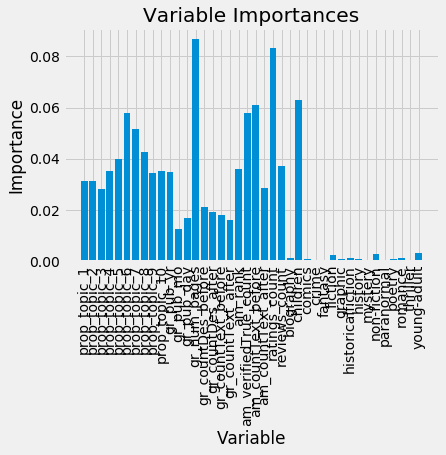

In [28]:
importances = list(rf.feature_importances_)

# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, features, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances')
plt.show()

Verdict: Better than the model w/o LDA & w/ LDA gen

# Xgboost

### XGB gen

In [28]:
xgb_gen = lda_gen.drop(['gr_pub_mo', 'gr_pub_day', 'gr_format', 'gr_description', 'gr_countDes_before', 'gr_countDes_after', 
                        'gr_genres', 'gr_countText_before', 'gr_countText_after', 'am_format', 'am_countText_after', 
                        'reviews_count'], axis=1) 
xgb_gen = pd.merge(xgb_gen, genres, how='left', on='asin')

In [29]:
y = np.array(xgb_gen['rating_diff'])
x = xgb_gen.drop('asin', axis=1).drop('rating_diff', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=0)

# fit model no training data
model = xgb.XGBRegressor(eta=0.1, min_child_weight=10, tree_method='approx')
model.fit(x_train, y_train)

# make predictions for train data
y_pred = model.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
r2 = model.score(x_train, y_train)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# make predictions for test data
y_pred = model.predict(x_test)
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = model.score(x_test, y_test)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.19853487651300472
Mean Squared Error: 0.07296480818180238
Root Mean Squared Error: 0.27011998848993457
R2 Adjusted Score: 0.35226563478056927
----------------------------------
TEST DATA:
Mean Absolute Error: 0.21906072046731387
Mean Squared Error: 0.08958092678023954
Root Mean Squared Error: 0.29930072966873894
R2 Adjusted Score: 0.19267045663831028


Verdict: A little than model w/o LDA

### XGB mallet

In [29]:
xgb_mallet = lda_mallet.drop(['gr_pub_mo', 'gr_pub_day', 'gr_format', 'gr_description', 'gr_countDes_before', 
                              'gr_countDes_after', 'gr_genres', 'gr_countText_before', 'gr_countText_after', 'am_format', 
                              'am_countText_after', 'reviews_count'], axis=1) 
xgb_mallet = pd.merge(xgb_mallet, genres, how='left', on='asin')
xgb_mallet.isnull().sum()

asin                        0
prop_topic_1                0
prop_topic_2                0
prop_topic_3                0
prop_topic_4                0
prop_topic_5                0
prop_topic_6                0
prop_topic_7                0
prop_topic_8                0
prop_topic_9                0
prop_topic_10               0
gr_pub_yr                1445
gr_num_pages             1630
am_rank                     0
am_verifiedTrue_count       0
am_countText_before         0
ratings_count               0
rating_diff                 0
biography                   0
children                    0
comics                      0
crime                       0
fantasy                     0
fiction                     0
graphic                     0
historicalfiction           0
history                     0
mystery                     0
non-fiction                 0
paranormal                  0
poetry                      0
romance                     0
thriller                    0
young-adul

In [38]:
y = np.array(xgb_mallet['rating_diff'])
x = xgb_mallet.drop('asin', axis=1).drop('rating_diff', axis=1)
features = list(x.columns)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=0)

# fit model no training data
model = xgb.XGBRegressor(eta=0.1, min_child_weight=10, tree_method='approx')
model.fit(x_train, y_train)

# make predictions for train data
y_pred = model.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
r2 = model.score(x_train, y_train)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# make predictions for test data
y_pred = model.predict(x_test)
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = model.score(x_test, y_test)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.19486709062959384
Mean Squared Error: 0.07076167341963924
Root Mean Squared Error: 0.2660106641088647
R2 Adjusted Score: 0.3718236399644781
----------------------------------
TEST DATA:
Mean Absolute Error: 0.21702461432662787
Mean Squared Error: 0.08788603953607708
Root Mean Squared Error: 0.2964557969345128
R2 Adjusted Score: 0.2079452767820672


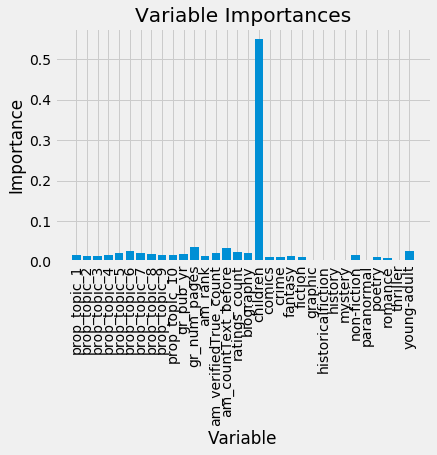

In [39]:
importances = list(model.feature_importances_)

# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, features, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances')
plt.show()

Verdict: Better than model w/o LDA & w/ LDA gen. Not as good as RF w/ LDA mallet except for R2 Adjusted.

### XGB mallet w/ null removed

In [40]:
xgb_mallet_2 = lda_mallet.drop(['gr_format', 'gr_description', 'gr_genres', 'am_format'], axis=1) 
xgb_mallet_2 = xgb_mallet_2.dropna()
xgb_mallet_2 = pd.merge(xgb_mallet_2, genres, how='left', on='asin')
xgb_mallet_2.isnull().sum()

asin                     0
prop_topic_1             0
prop_topic_2             0
prop_topic_3             0
prop_topic_4             0
prop_topic_5             0
prop_topic_6             0
prop_topic_7             0
prop_topic_8             0
prop_topic_9             0
prop_topic_10            0
gr_pub_yr                0
gr_pub_mo                0
gr_pub_day               0
gr_num_pages             0
gr_countDes_before       0
gr_countDes_after        0
gr_countText_before      0
gr_countText_after       0
am_rank                  0
am_verifiedTrue_count    0
am_countText_before      0
am_countText_after       0
ratings_count            0
reviews_count            0
rating_diff              0
biography                0
children                 0
comics                   0
crime                    0
fantasy                  0
fiction                  0
graphic                  0
historicalfiction        0
history                  0
mystery                  0
non-fiction              0
p

In [41]:
y = np.array(xgb_mallet_2['rating_diff'])
x = xgb_mallet_2.drop('asin', axis=1).drop('rating_diff', axis=1)
features = list(x.columns)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=0)

# fit model no training data
model = xgb.XGBRegressor(eta=0.1, min_child_weight=10, tree_method='approx')
model.fit(x_train, y_train)

# make predictions for train data
y_pred = model.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
r2 = model.score(x_train, y_train)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# make predictions for test data
y_pred = model.predict(x_test)
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = model.score(x_test, y_test)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.1883286662159504
Mean Squared Error: 0.0652517491776496
Root Mean Squared Error: 0.25544421930756156
R2 Adjusted Score: 0.4141417282696216
----------------------------------
TEST DATA:
Mean Absolute Error: 0.21798319724970056
Mean Squared Error: 0.09007134901267383
Root Mean Squared Error: 0.30011889146248993
R2 Adjusted Score: 0.19667674217506426


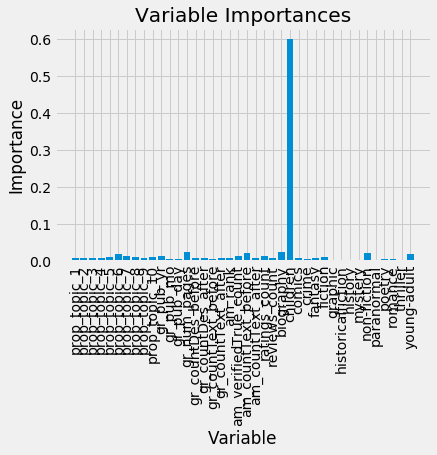

In [42]:
importances = list(model.feature_importances_)

# Set the style
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, features, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.title('Variable Importances')
plt.show()

Verdict: Not as good as the model w/o removing null

# Neural Network

### NN gen

In [32]:
nn_gen = lda_gen.drop(['gr_format', 'gr_description', 'gr_genres', 'am_format'], axis=1) 
nn_gen = nn_gen.dropna()
nn_gen.isnull().sum()

asin                     0
prop_topic_1             0
prop_topic_2             0
prop_topic_3             0
prop_topic_4             0
prop_topic_5             0
prop_topic_6             0
prop_topic_7             0
prop_topic_8             0
prop_topic_9             0
prop_topic_10            0
gr_pub_yr                0
gr_pub_mo                0
gr_pub_day               0
gr_num_pages             0
gr_countDes_before       0
gr_countDes_after        0
gr_countText_before      0
gr_countText_after       0
am_rank                  0
am_verifiedTrue_count    0
am_countText_before      0
am_countText_after       0
ratings_count            0
reviews_count            0
rating_diff              0
dtype: int64

In [33]:
nn_gen = pd.merge(nn_gen, genres, how='left', on='asin')
nn_gen.isnull().sum()

asin                     0
prop_topic_1             0
prop_topic_2             0
prop_topic_3             0
prop_topic_4             0
prop_topic_5             0
prop_topic_6             0
prop_topic_7             0
prop_topic_8             0
prop_topic_9             0
prop_topic_10            0
gr_pub_yr                0
gr_pub_mo                0
gr_pub_day               0
gr_num_pages             0
gr_countDes_before       0
gr_countDes_after        0
gr_countText_before      0
gr_countText_after       0
am_rank                  0
am_verifiedTrue_count    0
am_countText_before      0
am_countText_after       0
ratings_count            0
reviews_count            0
rating_diff              0
biography                0
children                 0
comics                   0
crime                    0
fantasy                  0
fiction                  0
graphic                  0
historicalfiction        0
history                  0
mystery                  0
non-fiction              0
p

In [34]:
y = np.array(nn_gen['rating_diff'])
x = nn_gen.drop('asin', axis=1).drop('rating_diff', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=0)
# normalize features
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
# fit model no training data
model = MLPRegressor(hidden_layer_sizes=(14,), solver='lbfgs', alpha=0.002, max_iter=500)
model.fit(x_train, y_train)

# make predictions for train data
y_pred = model.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
r2 = model.score(x_train, y_train)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# make predictions for test data
y_pred = model.predict(x_test)
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = model.score(x_test, y_test)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.22320938663686138
Mean Squared Error: 0.0923981836802762
Root Mean Squared Error: 0.30397069543012895
R2 Adjusted Score: 0.17040936244366067
----------------------------------
TEST DATA:
Mean Absolute Error: 0.2274558781686148
Mean Squared Error: 0.09693540705385784
Root Mean Squared Error: 0.31134451505343375
R2 Adjusted Score: 0.13545796919135444


C:\Users\Tu Lam\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Verdict: Improvement from the model w/o LDA

### NN mallet

In [35]:
nn_mallet = lda_mallet.drop(['gr_format', 'gr_description', 'gr_genres', 'am_format'], axis=1) 
nn_mallet = nn_mallet.dropna()
nn_mallet.isnull().sum()

asin                     0
prop_topic_1             0
prop_topic_2             0
prop_topic_3             0
prop_topic_4             0
prop_topic_5             0
prop_topic_6             0
prop_topic_7             0
prop_topic_8             0
prop_topic_9             0
prop_topic_10            0
gr_pub_yr                0
gr_pub_mo                0
gr_pub_day               0
gr_num_pages             0
gr_countDes_before       0
gr_countDes_after        0
gr_countText_before      0
gr_countText_after       0
am_rank                  0
am_verifiedTrue_count    0
am_countText_before      0
am_countText_after       0
ratings_count            0
reviews_count            0
rating_diff              0
dtype: int64

In [43]:
y = np.array(nn_mallet['rating_diff'])
x = nn_mallet.drop('asin', axis=1).drop('rating_diff', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=0)
# normalize features
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
# fit model no training data
model = MLPRegressor(hidden_layer_sizes=(14,), solver='lbfgs', alpha=0.002, max_iter=500)
model.fit(x_train, y_train)

# make predictions for train data
y_pred = model.predict(x_train)
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
r2 = model.score(x_train, y_train)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# make predictions for test data
y_pred = model.predict(x_test)
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = model.score(x_test, y_test)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.22264850291587582
Mean Squared Error: 0.09205423249822796
Root Mean Squared Error: 0.3034044042169262
R2 Adjusted Score: 0.17402581060175937
----------------------------------
TEST DATA:
Mean Absolute Error: 0.22471216431434907
Mean Squared Error: 0.09442952920553876
Root Mean Squared Error: 0.3072938808462329
R2 Adjusted Score: 0.15942549088341085


C:\Users\Tu Lam\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Verdict: Likewise, better than the model w/o LDA & model w/ just LDA gen

# Discussion

The models test performance from best to least in order are: Xgboost > RF > NN. <br/>
But the train/test prediction difference of the models from smallest to biggest in order are: NN > Xgboost > RF. <br/>
Best models overall: Xgboost & NN <br/>
Test out some weighted average ensembles and compare with individual models. Start w/ <br/>
1. Equal weights for all 3
2. Equal weights for just Xgboost & NN
3. Higher weights for Xgboost & NN (equal or one higher than the other) than RF

# Ensemble

### Equal weights for all 3

In [61]:
model1 = RandomForestRegressor(n_estimators = 1155, min_samples_split = 35, min_samples_leaf = 3, max_leaf_nodes = 7000,
                               max_features = 'auto', max_depth = 30, bootstrap = True, n_jobs=4)
model2 = xgb.XGBRegressor(eta=0.1, min_child_weight=10, tree_method='approx')
model3= MLPRegressor(hidden_layer_sizes=(14,), solver='lbfgs', alpha=0.002, max_iter=500)

y = np.array(nn_mallet['rating_diff'])
x = nn_mallet.drop('asin', axis=1).drop('rating_diff', axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.25, random_state=0)

model1.fit(x_train, y_train)
model2.fit(x_train, y_train)

scaler = StandardScaler()
scaler.fit(x_train)
x_train_nn = scaler.transform(x_train)
x_test_nn = scaler.transform(x_test)

model3.fit(x_train_nn, y_train)

# make predictions for train data
model1_pred = np.array(model1.predict(x_train))
model2_pred = np.array(model2.predict(x_train))
model3_pred = np.array(model3.predict(x_train_nn))
y_pred = (model1_pred + model2_pred + model3_pred)/3
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
r2 = r2_score(y_train, y_pred)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# make predictions for test data
model1_pred = np.array(model1.predict(x_test))
model2_pred = np.array(model2.predict(x_test))
model3_pred = np.array(model3.predict(x_test_nn))
y_pred = (model1_pred + model2_pred + model3_pred)/3
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

C:\Users\Tu Lam\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


TRAIN DATA:
Mean Absolute Error: 0.1892909082231817
Mean Squared Error: 0.06735065130875274
Root Mean Squared Error: 0.25952004028350634
R2 Adjusted Score: 0.39568341280493025
----------------------------------
TEST DATA:
Mean Absolute Error: 0.2173961323400811
Mean Squared Error: 0.08976584803896867
Root Mean Squared Error: 0.2996094925715283
R2 Adjusted Score: 0.2009397453782431


### Equal weights w/ just XGB & NN

In [62]:
# make predictions for train data
model2_pred = np.array(model2.predict(x_train))
model3_pred = np.array(model3.predict(x_train_nn))
y_pred = (model2_pred + model3_pred)/2
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
r2 = r2_score(y_train, y_pred)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# make predictions for test data
model2_pred = np.array(model2.predict(x_test))
model3_pred = np.array(model3.predict(x_test_nn))
y_pred = (model2_pred + model3_pred)/2
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.2035647868963323
Mean Squared Error: 0.07682296379823761
Root Mean Squared Error: 0.2771695578490495
R2 Adjusted Score: 0.3106912791691443
----------------------------------
TEST DATA:
Mean Absolute Error: 0.21853293960487824
Mean Squared Error: 0.09032138765636519
Root Mean Squared Error: 0.30053516875128805
R2 Adjusted Score: 0.19599455031991064


### Higher but equal weights for XGB & NN than RF

In [82]:
# make predictions for train data
model1_pred = np.array(model1.predict(x_train))
model2_pred = np.array(model2.predict(x_train))
model3_pred = np.array(model3.predict(x_train_nn))
y_pred = (model1_pred + (2*model2_pred) + (2*model3_pred))/5
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
r2 = r2_score(y_train, y_pred)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# make predictions for test data
model1_pred = np.array(model1.predict(x_test))
model2_pred = np.array(model2.predict(x_test))
model3_pred = np.array(model3.predict(x_test_nn))
y_pred = (model1_pred + (2*model2_pred) + (2*model3_pred))/5
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.19490386182604677
Mean Squared Error: 0.07100842861685408
Root Mean Squared Error: 0.2664740674378167
R2 Adjusted Score: 0.36286330703612224
----------------------------------
TEST DATA:
Mean Absolute Error: 0.21773139032792438
Mean Squared Error: 0.08991301773764433
Root Mean Squared Error: 0.2998549945184244
R2 Adjusted Score: 0.19962969863479418


### XGB > RF > NN

In [83]:
# make predictions for train data
model1_pred = np.array(model1.predict(x_train))
model2_pred = np.array(model2.predict(x_train))
model3_pred = np.array(model3.predict(x_train_nn))
y_pred = ((2*model1_pred) + (3*model2_pred) + model3_pred)/6
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
r2 = r2_score(y_train, y_pred)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# make predictions for test data
model1_pred = np.array(model1.predict(x_test))
model2_pred = np.array(model2.predict(x_test))
model3_pred = np.array(model3.predict(x_test_nn))
y_pred = ((2*model1_pred) + (3*model2_pred) + model3_pred)/6
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.18420263435860001
Mean Squared Error: 0.06354196572582262
Root Mean Squared Error: 0.25207531756564866
R2 Adjusted Score: 0.4298575719028732
----------------------------------
TEST DATA:
Mean Absolute Error: 0.21719317274096386
Mean Squared Error: 0.08947013982886359
Root Mean Squared Error: 0.2991155960976686
R2 Adjusted Score: 0.20357202349762016


### XGB > NN > RF

In [88]:
# make predictions for train data
model1_pred = np.array(model1.predict(x_train))
model2_pred = np.array(model2.predict(x_train))
model3_pred = np.array(model3.predict(x_train_nn))
y_pred = (model1_pred + (3*model2_pred) + (2*model3_pred))/6
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
r2 = r2_score(y_train, y_pred)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# make predictions for test data
model1_pred = np.array(model1.predict(x_test))
model2_pred = np.array(model2.predict(x_test))
model3_pred = np.array(model3.predict(x_test_nn))
y_pred = (model1_pred + (3*model2_pred) + (2*model3_pred))/6
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.19359473728290522
Mean Squared Error: 0.06987182398221092
Root Mean Squared Error: 0.26433279021379646
R2 Adjusted Score: 0.37306170928540217
----------------------------------
TEST DATA:
Mean Absolute Error: 0.21756600866549955
Mean Squared Error: 0.08971510810900224
Root Mean Squared Error: 0.29952480382933605
R2 Adjusted Score: 0.201391412267647


### NN > XGB > RF

In [85]:
# make predictions for train data
model1_pred = np.array(model1.predict(x_train))
model2_pred = np.array(model2.predict(x_train))
model3_pred = np.array(model3.predict(x_train_nn))
y_pred = (model1_pred + (2*model2_pred) + (3*model3_pred))/6
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
r2 = r2_score(y_train, y_pred)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# make predictions for test data
model1_pred = np.array(model1.predict(x_test))
model2_pred = np.array(model2.predict(x_test))
model3_pred = np.array(model3.predict(x_test_nn))
y_pred = (model1_pred + (2*model2_pred) + (3*model3_pred))/6
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.19922812338038473
Mean Squared Error: 0.07416958259968126
Root Mean Squared Error: 0.27234093081959104
R2 Adjusted Score: 0.33449924894048855
----------------------------------
TEST DATA:
Mean Absolute Error: 0.21830729707633187
Mean Squared Error: 0.09033187450583674
Root Mean Squared Error: 0.3005526152037888
R2 Adjusted Score: 0.19590120051269588


### XGB > NN

In [91]:
# make predictions for train data
model2_pred = np.array(model2.predict(x_train))
model3_pred = np.array(model3.predict(x_train_nn))
y_pred = ((2*model2_pred) + model3_pred)/2
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
r2 = r2_score(y_train, y_pred)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# make predictions for test data
model2_pred = np.array(model2.predict(x_test))
model3_pred = np.array(model3.predict(x_test_nn))
y_pred = ((2*model2_pred) + model3_pred)/2
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.2499729920766883
Mean Squared Error: 0.10607618531281983
Root Mean Squared Error: 0.32569339157069155
R2 Adjusted Score: 0.04821115987360469
----------------------------------
TEST DATA:
Mean Absolute Error: 0.2704075872007369
Mean Squared Error: 0.1298744215367733
Root Mean Squared Error: 0.36038093947484695
R2 Adjusted Score: -0.15609099238917823


### NN > XGB

In [92]:
# make predictions for train data
model2_pred = np.array(model2.predict(x_train))
model3_pred = np.array(model3.predict(x_train_nn))
y_pred = (model2_pred + (2*model3_pred))/2
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
r2 = r2_score(y_train, y_pred)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# make predictions for test data
model2_pred = np.array(model2.predict(x_test))
model3_pred = np.array(model3.predict(x_test_nn))
y_pred = (model2_pred + (2*model3_pred))/2
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.26077908346119133
Mean Squared Error: 0.11798163285208894
Root Mean Squared Error: 0.34348454528856015
R2 Adjusted Score: -0.0586127428824188
----------------------------------
TEST DATA:
Mean Absolute Error: 0.269961762609331
Mean Squared Error: 0.1307430109495287
Root Mean Squared Error: 0.3615840302744698
R2 Adjusted Score: -0.16382283353456328


In [86]:
"""
### NOTE: RANKED FROM WORST TO BEST TEST PERFORMANCE

ENSEMBLE - XGB > NN:
    TRAIN DATA:
    Mean Absolute Error: 0.2499729920766883
    Mean Squared Error: 0.10607618531281983
    Root Mean Squared Error: 0.32569339157069155
    R2 Adjusted Score: 0.04821115987360469
    ----------------------------------
    TEST DATA:
    Mean Absolute Error: 0.2704075872007369
    Mean Squared Error: 0.1298744215367733
    Root Mean Squared Error: 0.36038093947484695
    R2 Adjusted Score: -0.15609099238917823

ENSEMBLE - NN > XGB:
    TRAIN DATA:
    Mean Absolute Error: 0.26077908346119133
    Mean Squared Error: 0.11798163285208894
    Root Mean Squared Error: 0.34348454528856015
    R2 Adjusted Score: -0.0586127428824188
    ----------------------------------
    TEST DATA:
    Mean Absolute Error: 0.269961762609331
    Mean Squared Error: 0.1307430109495287
    Root Mean Squared Error: 0.3615840302744698
    R2 Adjusted Score: -0.16382283353456328

NN MALLET
    TRAIN DATA:
    Mean Absolute Error: 0.22242721938169951
    Mean Squared Error: 0.09188023591544606
    Root Mean Squared Error: 0.3031175282220513
    R2 Adjusted Score: 0.17558702818536265
    ----------------------------------
    TEST DATA:
    Mean Absolute Error: 0.2240292780327175
    Mean Squared Error: 0.09415299768668209
    Root Mean Squared Error: 0.30684360460449894
    R2 Adjusted Score: 0.1618870656436987

ENSEMBLE - EQUAL WEIGHTS FOR JUST XGB & NN:
    TRAIN DATA:
    Mean Absolute Error: 0.2035647868963323
    Mean Squared Error: 0.07682296379823761
    Root Mean Squared Error: 0.2771695578490495
    R2 Adjusted Score: 0.3106912791691443
    ----------------------------------
    TEST DATA:
    Mean Absolute Error: 0.21853293960487824
    Mean Squared Error: 0.09032138765636519
    Root Mean Squared Error: 0.30053516875128805
    R2 Adjusted Score: 0.19599455031991064

ENSEMBLE - NN > XGB > RF:
    TRAIN DATA:
    Mean Absolute Error: 0.19922812338038473
    Mean Squared Error: 0.07416958259968126
    Root Mean Squared Error: 0.27234093081959104
    R2 Adjusted Score: 0.33449924894048855
    ----------------------------------
    TEST DATA:
    Mean Absolute Error: 0.21830729707633187
    Mean Squared Error: 0.09033187450583674
    Root Mean Squared Error: 0.3005526152037888
    R2 Adjusted Score: 0.19590120051269588

RF MALLET
    TRAIN DATA:
    Mean Absolute Error: 0.1629107330152026
    Mean Squared Error: 0.05143697030068982
    Root Mean Squared Error: 0.22679720082198945
    R2 Adjusted Score: 0.5381767553638106
    ----------------------------------
    TEST DATA:
    Mean Absolute Error: 0.21773554131645412
    Mean Squared Error: 0.09025789502980511
    Root Mean Squared Error: 0.30042951757409775
    R2 Adjusted Score: 0.19501298609881101  
    
ENSEMBLE - HIGHER BUT EQUAL WEIGHTS FOR XGB & NN THAN RF:
    TRAIN DATA:
    Mean Absolute Error: 0.19490386182604677
    Mean Squared Error: 0.07100842861685408
    Root Mean Squared Error: 0.2664740674378167
    R2 Adjusted Score: 0.36286330703612224
    ----------------------------------
    TEST DATA:
    Mean Absolute Error: 0.21773139032792438
    Mean Squared Error: 0.08991301773764433
    Root Mean Squared Error: 0.2998549945184244
    R2 Adjusted Score: 0.19962969863479418
  
XGB MALLET NO NULLS
    TRAIN DATA:
    Mean Absolute Error: 0.1883286662159504
    Mean Squared Error: 0.0652517491776496
    Root Mean Squared Error: 0.25544421930756156
    R2 Adjusted Score: 0.4141417282696216
    ----------------------------------
    TEST DATA:
    Mean Absolute Error: 0.21798319724970056
    Mean Squared Error: 0.09007134901267383
    Root Mean Squared Error: 0.30011889146248993
    R2 Adjusted Score: 0.19667674217506426

ENSEMBLE - XGB > NN > RF:
    TRAIN DATA:
    Mean Absolute Error: 0.19359473728290522
    Mean Squared Error: 0.06987182398221092
    Root Mean Squared Error: 0.26433279021379646
    R2 Adjusted Score: 0.37306170928540217
    ----------------------------------
    TEST DATA:
    Mean Absolute Error: 0.21756600866549955
    Mean Squared Error: 0.08971510810900224
    Root Mean Squared Error: 0.29952480382933605
    R2 Adjusted Score: 0.201391412267647

ENSEMBLE - EQUAL WEIGHTS FOR ALL 3:
    TRAIN DATA:
    Mean Absolute Error: 0.1892909082231817
    Mean Squared Error: 0.06735065130875274
    Root Mean Squared Error: 0.25952004028350634
    R2 Adjusted Score: 0.39568341280493025
    ----------------------------------
    TEST DATA:
    Mean Absolute Error: 0.2173961323400811
    Mean Squared Error: 0.08976584803896867
    Root Mean Squared Error: 0.2996094925715283
    R2 Adjusted Score: 0.2009397453782431
    
ENSEMBLE - XGB > RF > NN:
    TRAIN DATA:
    Mean Absolute Error: 0.18420263435860001
    Mean Squared Error: 0.06354196572582262
    Root Mean Squared Error: 0.25207531756564866
    R2 Adjusted Score: 0.4298575719028732
    ----------------------------------
    TEST DATA:
    Mean Absolute Error: 0.21719317274096386
    Mean Squared Error: 0.08947013982886359
    Root Mean Squared Error: 0.2991155960976686
    R2 Adjusted Score: 0.20357202349762016
    
XGB MALLET
    TRAIN DATA:
    Mean Absolute Error: 0.19486709062959384
    Mean Squared Error: 0.07076167341963924
    Root Mean Squared Error: 0.2660106641088647
    R2 Adjusted Score: 0.3718236399644781
    ----------------------------------
    TEST DATA:
    Mean Absolute Error: 0.21702461432662787
    Mean Squared Error: 0.08788603953607708
    Root Mean Squared Error: 0.2964557969345128
    R2 Adjusted Score: 0.2079452767820672    
""";

So far, it seems like the ensemble w/ XGB > RF > NN has best chances at beating XGB Mallet. Let's tweak the weights

In [108]:
# make predictions for train data
model1_pred = np.array(model1.predict(x_train))
model2_pred = np.array(model2.predict(x_train))
model3_pred = np.array(model3.predict(x_train_nn))
y_pred = ((43*model1_pred) + (45*model2_pred) + (12*model3_pred))/100
print('TRAIN DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_train, y_pred))
print('Mean Squared Error:', mean_squared_error(y_train, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_train, y_pred)))
r2 = r2_score(y_train, y_pred)
n = x_train.shape[0]
p = x_train.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

print('----------------------------------')

# make predictions for test data
model1_pred = np.array(model1.predict(x_test))
model2_pred = np.array(model2.predict(x_test))
model3_pred = np.array(model3.predict(x_test_nn))
y_pred = ((43*model1_pred) + (45*model2_pred) + (12*model3_pred))/100
print('TEST DATA:')
print('Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_pred)))
r2 = r2_score(y_test, y_pred)
n = x_test.shape[0]
p = x_test.shape[1]
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print('R2 Adjusted Score:', adjusted_r2)

TRAIN DATA:
Mean Absolute Error: 0.18038588687997759
Mean Squared Error: 0.06115359947434676
Root Mean Squared Error: 0.2472925382504429
R2 Adjusted Score: 0.451287644426555
----------------------------------
TEST DATA:
Mean Absolute Error: 0.21716372915245075
Mean Squared Error: 0.08947770025657142
Root Mean Squared Error: 0.29912823380044123
R2 Adjusted Score: 0.20350472354534155


XGB is still the best model. Ensemble did not help much